# Indicateur données officielles par région / département

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Avec données officielles mensuelles

In [2]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])
df_France_Official_Data2.head(3)

,date,department,value_in_thousands
0,2011-01-01,Ain,47.32
1,2011-01-01,Aisne,21.78
2,2011-01-01,Allier,23.62


In [3]:
#Base avec les régions :
base_regions_dep = pd.read_csv('departements-region.csv')
base_regions_dep.rename(columns={'dep_name': 'department'}, inplace=True)
base_regions_dep.head(3)

,num_dep,department,region_name
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes


In [4]:
base_regions_dep["region_name"].unique()

array(['Auvergne-Rhône-Alpes', 'Hauts-de-France',
       "Provence-Alpes-Côte d'Azur", 'Grand Est', 'Occitanie',
       'Normandie', 'Nouvelle-Aquitaine', 'Centre-Val de Loire',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Corse', 'Pays de la Loire',
       'Île-de-France', 'Guadeloupe', 'Martinique', 'Guyane',
       'La Réunion', 'Mayotte'], dtype=object)

In [5]:
#On merge pour rajouter la colonne région
df_France_Official_Data3 = df_France_Official_Data2.merge(base_regions_dep, on='department', how='left')
df_France_Official_Data3.head(3)

,date,department,value_in_thousands,num_dep,region_name
0,2011-01-01,Ain,47.32,01,Auvergne-Rhône-Alpes
1,2011-01-01,Aisne,21.78,02,Hauts-de-France
2,2011-01-01,Allier,23.62,03,Auvergne-Rhône-Alpes


In [6]:
#Fonction qui réduit la base des données officielles à 1 seul département :

def reduc_base_departement(departement):
       
    #Données département
    df_Official_Data_dep = df_France_Official_Data3[df_France_Official_Data3['department']==departement]
    
    #On regroupe par mois
    df_Official_Data_dep2 = df_Official_Data_dep.groupby('date').sum() 

    return(df_Official_Data_dep2)

In [7]:
#Fonction qui réduit la base des données officielles à 1 seule région :

def reduc_base_region(region):
        
    #Données région
    df_Official_Data_region = df_France_Official_Data3[df_France_Official_Data3['region_name']==region]
    
    #On regroupe par mois
    df_Official_Data_region2 = df_Official_Data_region.groupby('date').sum() 

    return(df_Official_Data_region2)

In [8]:
reduc_base_departement("Paris")

,value_in_thousands
date,
2011-01-01,1106.32
2011-02-01,1020.39
2011-03-01,1314.42
2011-04-01,1329.35
2011-05-01,1390.83
...,...
2021-06-01,592.97
2021-07-01,798.10
2021-08-01,769.23


In [9]:
#reduc_base_region("Pays de la Loire")

In [10]:
def differencie_acf_pacf(dep_region):
    
    #on importe les données officielles pour le département ou la région demandé(e) :
    if (dep_region in df_France_Official_Data3["region_name"].unique()):
        df_Official_Data = reduc_base_region(dep_region)
        print("region")
    elif (dep_region in df_France_Official_Data3["department"].unique()):
        df_Official_Data = reduc_base_departement(dep_region)
        print("departement")
    else:
        print(dep_region, " n'est ni un département, ni une région française.")
        return None
    
    #Test ADF série initiale
    result1 = adfuller(df_Official_Data['value_in_thousands'])
    print('Statistiques ADF : {}'.format(result1[0]))
    print('p-value : {}'.format(result1[1]))
    print('Valeurs Critiques :')
    for key, value in result1[4].items():
        print('\t{}: {}'.format(key, value))
    
    df_Official_Data["valeur_differenciee"] = df_Official_Data["value_in_thousands"].diff()
    df_Official_Data.dropna(inplace=True)
    
    #Test ADF série différenciée
    result2 = adfuller(df_Official_Data['valeur_differenciee'])
    print('Statistiques ADF : {}'.format(result2[0]))
    print('p-value : {}'.format(result2[1]))
    print('Valeurs Critiques :')
    for key, value in result2[4].items():
        print('\t{}: {}'.format(key, value))
    
    if (result2[1]<0.05):
        plot_acf(df_Official_Data["valeur_differenciee"], title=region); 
        plot_pacf(df_Official_Data["valeur_differenciee"], title=region);
    
    else: #différenciation 2nde
        
        df_Official_Data["valeur_differenciee_ordre2"] = df_Official_Data["valeur_differenciee"].diff()
        df_Official_Data.dropna(inplace=True)
        
        result3 = adfuller(df_Official_Data['valeur_differenciee_ordre2'])
        print('Statistiques ADF : {}'.format(result3[0]))
        print('p-value : {}'.format(result3[1]))
        print('Valeurs Critiques :')
        for key, value in result3[4].items():
            print('\t{}: {}'.format(key, value))
        
        plot_acf(df_Official_Data["valeur_differenciee_ordre2"], title=region); 
        plot_pacf(df_Official_Data["valeur_differenciee_ordre2"], title=region);

In [11]:
#differencie_acf_pacf('Île-de-France')

In [12]:
def choix_modele_sarima(pmax, d, qmax, data):

    p = range(0, pmax)
    q = range(0, qmax)
    pdq = [(p,d,q) for p,q in itertools.product(p,q)]

    p2 = d2 = q2 = range(0, 2)
    seasonal_pdq = list(itertools.product(p2,d2,q2))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in seasonal_pdq]
    
    parametres_aic = {}
    parametres_bic = {}
    aics = []
    bics = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                parametres_aic.update({results.aic : [param, param_seasonal]})
                parametres_bic.update({results.bic : [param, param_seasonal]})
                aics.append(results.aic)
                bics.append(results.bic)


            except: 
                continue

    best_aic = min(aics)
    best_bic = min(bics)

    print(parametres_bic[best_bic])
    
    return(parametres_bic[best_bic])

In [13]:
def modele_donnees_off(dep_region, pmax, dmax, qmax):
    
    #on importe les données officielles pour le département ou la région demandé(e) :
    if (dep_region in df_France_Official_Data3["region_name"].unique()):
        df_Official_Data = reduc_base_region(dep_region)
    elif (dep_region in df_France_Official_Data3["department"].unique()):
        df_Official_Data = reduc_base_departement(dep_region)
    else:
        print(dep_region, " n'est ni un département, ni une région française.")
        return None
    
    #pour avoir une base où la colonne des dates n'est pas en index
    df_Official_Data_index = df_Official_Data.reset_index()
   
    #on imagine que l'on a toutes les données jusqu'à décembre 2017 de disponibles
    df_donnees_dispo = df_Official_Data_index[df_Official_Data_index['date']<"2018-01-01"]
    df_donnees_dispo.set_index('date', inplace=True)

    
    #choix du modèle qui minimise le BIC
    parametres_modele = choix_modele_sarima(pmax, dmax, qmax, df_donnees_dispo)
    
    #on fit le modèle sur ces données
    modele_prev = sm.tsa.statespace.SARIMAX(df_donnees_dispo,
                                            order=parametres_modele[0],
                                            seasonal_order=parametres_modele[1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    resultats_prev = modele_prev.fit()
    
    
    #on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

    df_forecast = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
    df_forecast['date'] = pd.DataFrame(pd.date_range("2018-01-01", "2021-10-01", freq="MS"))
    df_forecast.set_index('date', drop=False, inplace=True)
    
    
    #on remplit la base
    
    resultats_prev_new = resultats_prev

    for date in df_forecast['date']:

        #La valeur prédite :
        if ( float(resultats_prev_new.forecast(date)) >= 0):
            df_forecast.loc[date, 'valeur_predite'] = float(resultats_prev_new.forecast(date)) 
        else:
            df_forecast.loc[date, 'valeur_predite'] = 0
        #je mets dans le dataframe la prédiction pour la date

        # La nouvelle observation qu'on a à disposition
        new_data = df_Official_Data.loc[date, "value_in_thousands"]

        #La nouvelle observation qu'on a à disposition (sous forme de dataframe) :
        new_data2 = df_Official_Data_index[df_Official_Data_index['date']==date]
        new_data2.set_index('date', inplace=True)

        #On met la nouvelle observation dans le dataframe
        df_forecast.loc[date, 'donnee_officielle'] = new_data

        #Nouveau modèle fitté avec une donnée de plus :
        resultats_prev_new = resultats_prev_new.append(new_data2)

        
    df_forecast[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))
    plt.title("SARIMA en temps réel - données officielles mensuelles")
    plt.suptitle(dep_region)
    
    return(df_forecast)

In [14]:
#modele_donnees_off("Pays de la Loire", 4, 2, 4)

## Prédictions journalières interpolées

In [15]:
def modele_donnees_off_jour_interpole(dep_region, pmax, dmax, qmax):
    
    df = modele_donnees_off(dep_region, pmax, dmax, qmax)
      
    df[["valeur_predite", "donnee_officielle"]] = df[["valeur_predite", "donnee_officielle"]].apply(pd.to_numeric)
    df.reset_index(drop=True, inplace=True)

    df_days = pd.DataFrame(pd.date_range("2018-01-01", "2021-10-01")).rename(columns={0:"date"})
    df_interpolated = df_days.merge(df, how="left")
    df_interpolated.set_index('date', inplace=True)

    df_interpolated['valeur_predite'] = df_interpolated['valeur_predite'].interpolate(method='linear')
    df_interpolated['donnee_officielle'] = df_interpolated['donnee_officielle'].ffill()

    df_interpolated[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))
    plt.title("SARIMA en temps réel - interpolation des données officielles et des valeurs prédites")
    plt.suptitle(dep_region)

    
    return(df_interpolated)

In [16]:
#modele_donnees_off_jour_interpole('Île-de-France', 5, 3, 5)

### Pour trouver les ordres maximaux du SARIMA :

Bretagne
region
Statistiques ADF : -1.3532156570186509
p-value : 0.6044884642470133
Valeurs Critiques :
	1%: -3.487517288664615
	5%: -2.8865777180380032
	10%: -2.5801239192052012
Statistiques ADF : -4.0363606585009455
p-value : 0.0012316380841216302
Valeurs Critiques :
	1%: -3.487517288664615
	5%: -2.8865777180380032
	10%: -2.5801239192052012
Hauts-de-France
region
Statistiques ADF : -1.0116374198462943
p-value : 0.7489961904725204
Valeurs Critiques :
	1%: -3.485585145896754
	5%: -2.885738566292665
	10%: -2.5796759080663887
Statistiques ADF : -7.111206846689735
p-value : 3.934787460346279e-10
Valeurs Critiques :
	1%: -3.486055829282407
	5%: -2.8859430324074076
	10%: -2.5797850694444446
Bourgogne-Franche-Comté
region
Statistiques ADF : -1.3210266650450597
p-value : 0.6194985347135331
Valeurs Critiques :
	1%: -3.487517288664615
	5%: -2.8865777180380032
	10%: -2.5801239192052012
Statistiques ADF : -3.5978849600768212
p-value : 0.005801591751192623
Valeurs Critiques :
	1%: -3.4875172886646

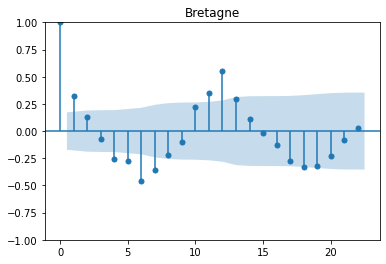

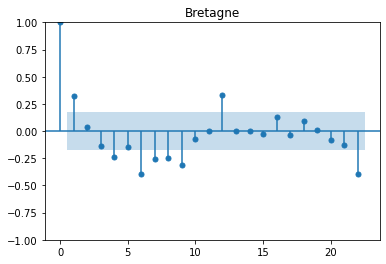

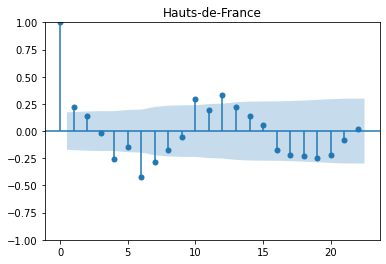

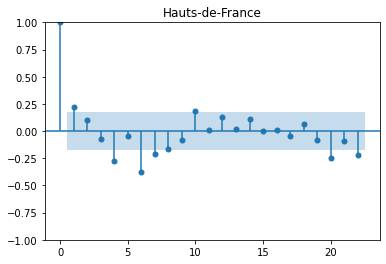

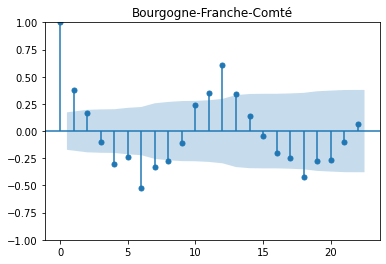

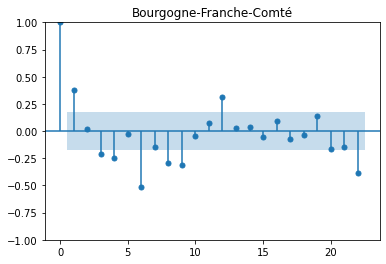

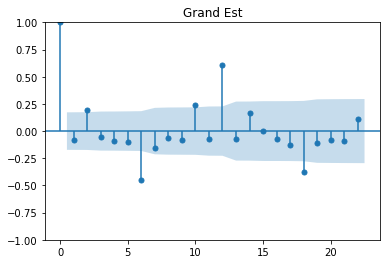

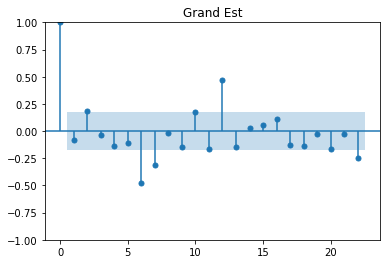

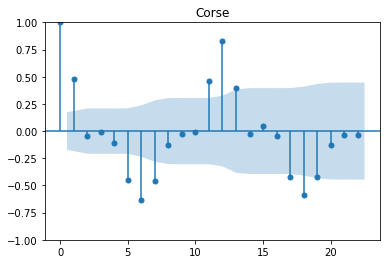

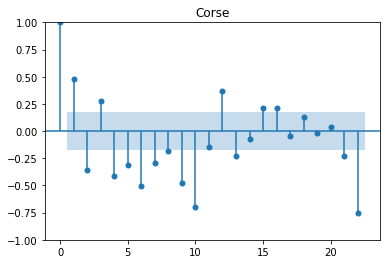

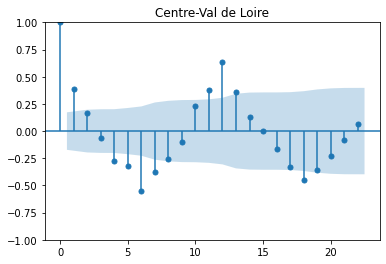

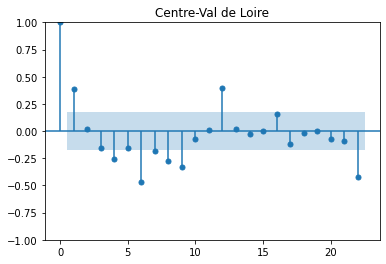

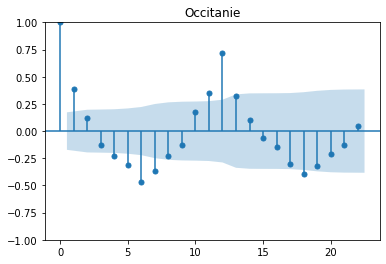

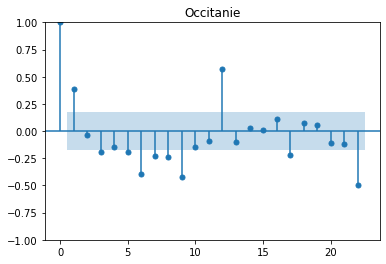

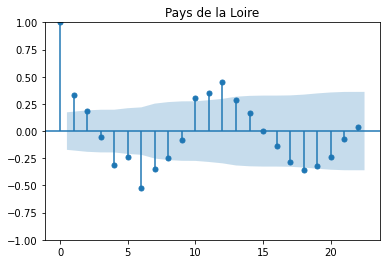

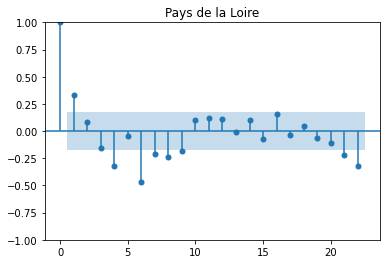

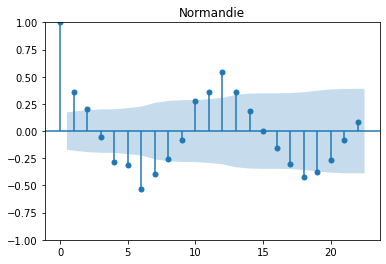

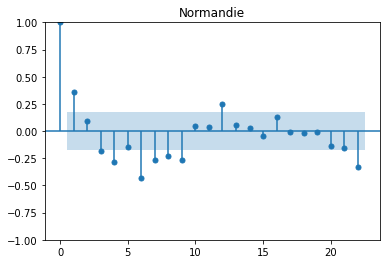

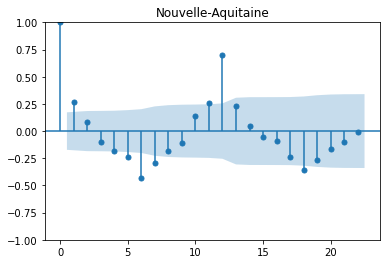

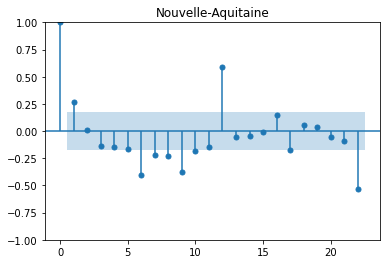

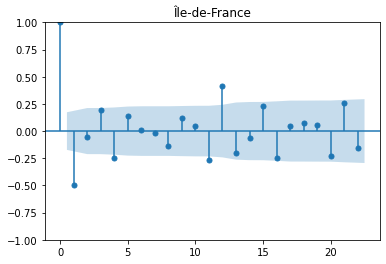

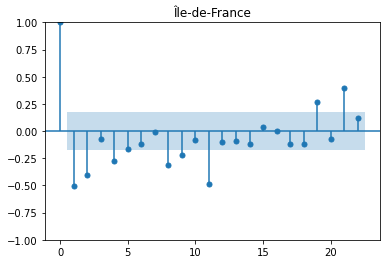

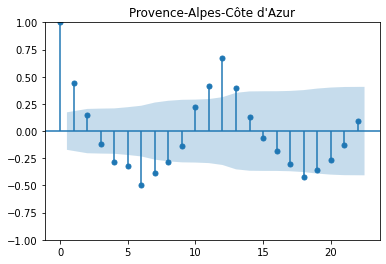

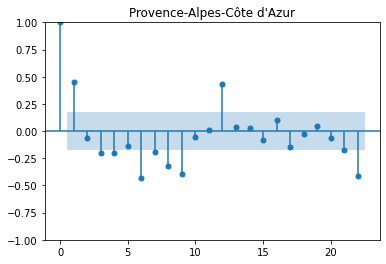

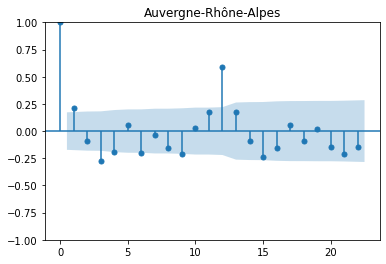

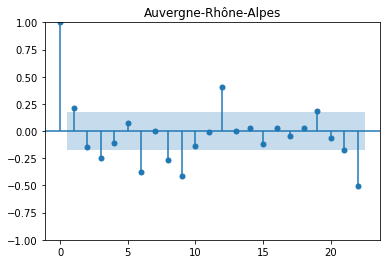

In [17]:
liste_regions = ['Bretagne', 'Hauts-de-France', 'Bourgogne-Franche-Comté', 'Grand Est', 'Corse', 'Centre-Val de Loire', 'Occitanie',
                 'Pays de la Loire', 'Normandie', 'Nouvelle-Aquitaine', 'Île-de-France', "Provence-Alpes-Côte d'Azur", "Auvergne-Rhône-Alpes"]

for region in liste_regions:
    print(region)
    differencie_acf_pacf(region)

Pour Ile de France : série différenciée n'est pas stationnaire.
Pour toutes les autres régions, série différenciée stationnaire.

### Base avec toutes les régions

In [18]:
#liste_regions = ['Bretagne', 'Hauts-de-France', 'Bourgogne-Franche-Comté', 'Grand Est', 'Corse', 'Centre-Val de Loire', 'Occitanie',
#                 'Pays de la Loire', 'Normandie', 'Nouvelle-Aquitaine', 'Île-de-France', "Provence-Alpes-Côte d'Azur", "Auvergne-Rhône-Alpes"]

#nb_touristes_sarima = pd.DataFrame()

#df_bretagne = modele_donnees_off_jour_interpole('Bretagne', 6, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Bretagne"}).reset_index()
#nb_touristes_sarima = df_bretagne

#df_hauts_france = modele_donnees_off_jour_interpole('Hauts-de-France', 5, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Hauts-de-France"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_hauts_france, on="date")

#df_bourgogne = modele_donnees_off_jour_interpole('Bourgogne-Franche-Comté', 5, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Bourgogne-Franche-Comté"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_bourgogne, on="date")

#df_grand_est = modele_donnees_off_jour_interpole('Grand Est', 4, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Grand Est"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_grand_est, on="date")

#df_centre = modele_donnees_off_jour_interpole('Centre-Val de Loire', 6, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Centre-Val de Loire"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_centre, on="date")

#df_occitanie = modele_donnees_off_jour_interpole('Occitanie', 5, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Occitanie"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_occitanie, on="date")

#df_pays_loire = modele_donnees_off_jour_interpole('Pays de la Loire', 6, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Pays de la Loire"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_pays_loire, on="date")

#df_normandie = modele_donnees_off_jour_interpole('Normandie', 6, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Normandie"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_normandie, on="date")

#df_nouvelle_aquitaine = modele_donnees_off_jour_interpole('Nouvelle-Aquitaine', 3, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Nouvelle-Aquitaine"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_nouvelle_aquitaine, on="date")

#df_ile_france = modele_donnees_off_jour_interpole('Île-de-France', 6, 2, 5).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Île-de-France"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_ile_france, on="date")

#df_paca = modele_donnees_off_jour_interpole("Provence-Alpes-Côte d'Azur", 6, 1, 6).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Provence-Alpes-Côte d'Azur"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_paca, on="date")

#df_auvergne_rhone_alpes = modele_donnees_off_jour_interpole("Auvergne-Rhône-Alpes", 5, 1, 5).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Auvergne-Rhône-Alpes"}).reset_index()
#nb_touristes_sarima = nb_touristes_sarima.merge(df_auvergne_rhone_alpes, on="date")

#nb_touristes_sarima

[(5, 1, 0), (1, 1, 1, 12)]
[(0, 1, 2), (0, 1, 1, 12)]
[(0, 1, 2), (0, 1, 1, 12)]
[(0, 1, 2), (0, 1, 1, 12)]
[(5, 1, 0), (1, 1, 0, 12)]
[(5, 1, 0), (1, 1, 1, 12)]
[(4, 1, 2), (1, 1, 0, 12)]
[(5, 1, 0), (1, 1, 0, 12)]
[(5, 1, 0), (1, 1, 1, 12)]
[(0, 1, 2), (0, 1, 1, 12)]
[(0, 2, 4), (0, 1, 1, 12)]
[(5, 1, 0), (1, 1, 0, 12)]
[(0, 1, 3), (0, 1, 1, 12)]


,date,Bretagne,Hauts-de-France,Bourgogne-Franche-Comté,Grand Est,Corse,Centre-Val de Loire,Occitanie,Pays de la Loire,Normandie,Nouvelle-Aquitaine,Île-de-France,Provence-Alpes-Côte d'Azur,Auvergne-Rhône-Alpes
0,2018-01-01,240.366053,348.504215,279.334014,495.596662,24.318664,204.755434,485.161548,245.299882,241.147464,489.795921,2556.671409,582.425875,974.032705
1,2018-01-02,241.434996,349.446339,281.289591,497.774001,24.596712,205.316895,487.449736,245.863217,242.418729,492.652638,2554.972344,584.592912,979.425094
2,2018-01-03,242.503939,350.388463,283.245167,499.951339,24.874760,205.878357,489.737924,246.426552,243.689995,495.509355,2553.273280,586.759950,984.817483
3,2018-01-04,243.572882,351.330587,285.200744,502.128677,25.152807,206.439818,492.026113,246.989887,244.961260,498.366072,2551.574215,588.926987,990.209871
4,2018-01-05,244.641826,352.272710,287.156321,504.306016,25.430855,207.001279,494.314301,247.553222,246.232526,501.222788,2549.875150,591.094025,995.602260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2021-09-27,311.769260,241.560235,417.163794,361.815087,122.396430,274.950195,1182.666867,333.351851,241.403661,686.428402,1739.329462,743.770997,701.571135
1366,2021-09-28,308.402874,241.087002,414.165170,361.920596,119.285460,274.115629,1180.945597,329.321902,239.452977,682.850979,1748.011122,740.384531,694.713546
1367,2021-09-29,305.036488,240.613770,411.166546,362.026105,116.174489,273.281062,1179.224327,325.291953,237.502292,679.273557,1756.692783,736.998064,687.855957
1368,2021-09-30,301.670102,240.140538,408.167921,362.131614,113.063518,272.446496,1177.503058,321.262004,235.551607,675.696135,1765.374444,733.611597,680.998368


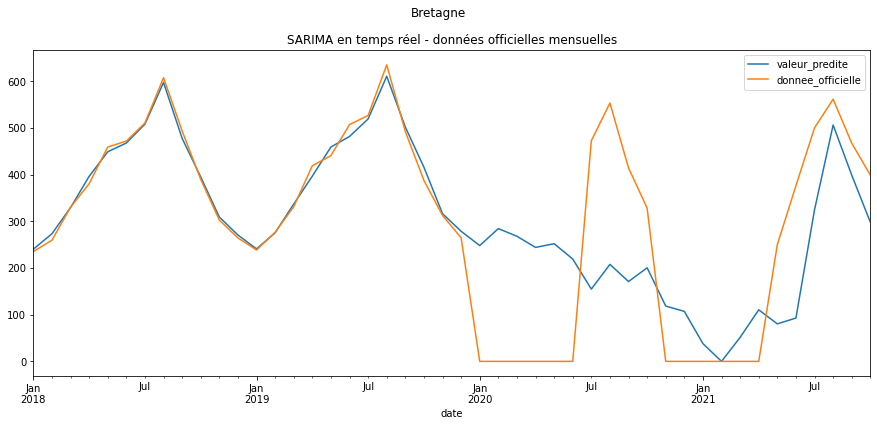

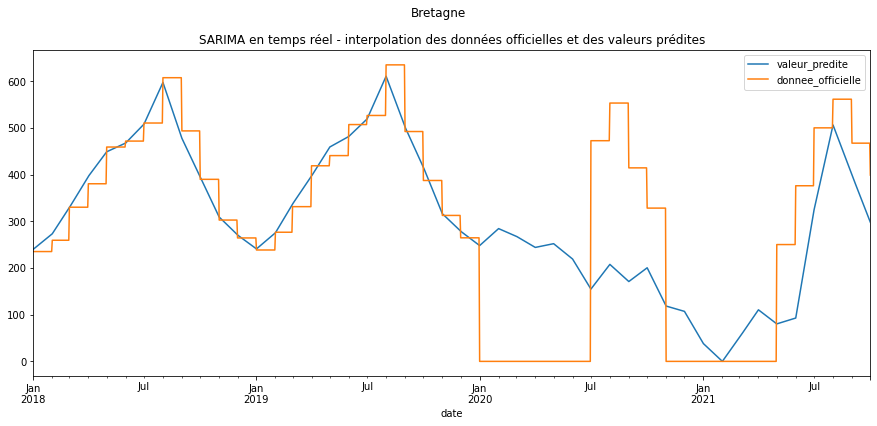

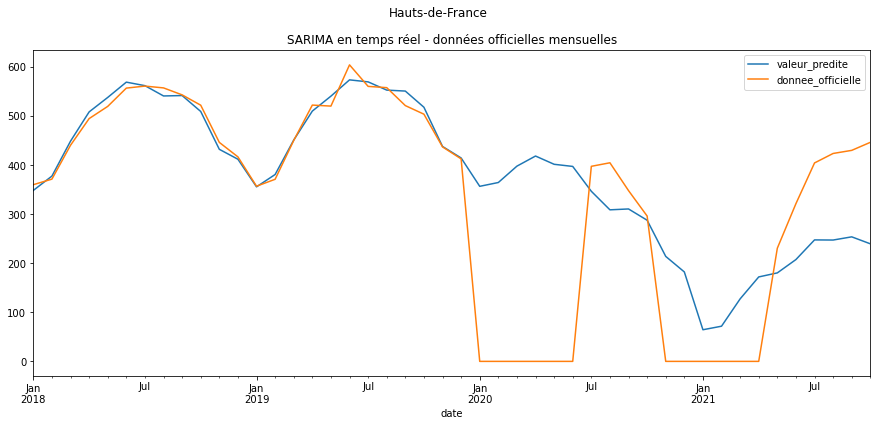

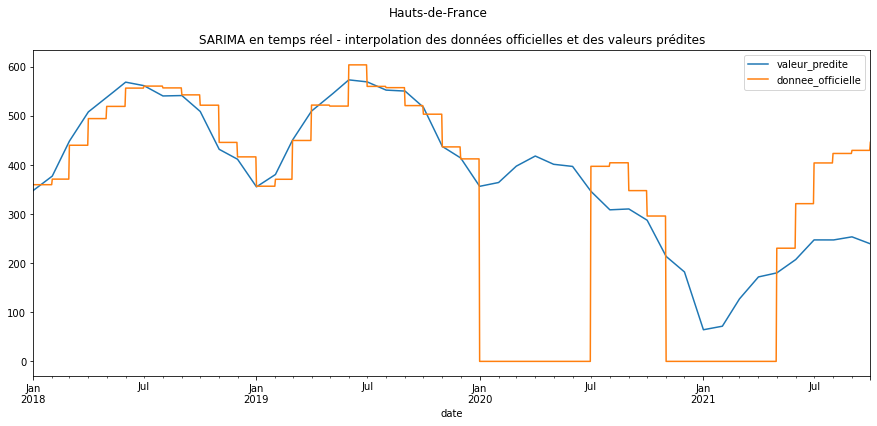

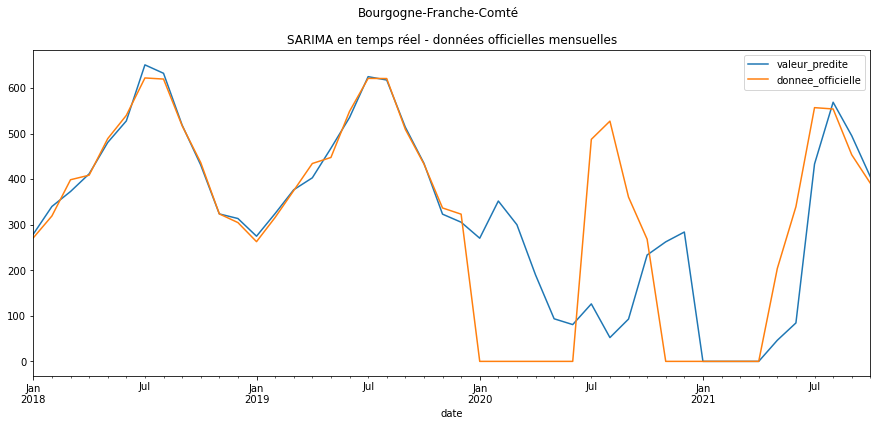

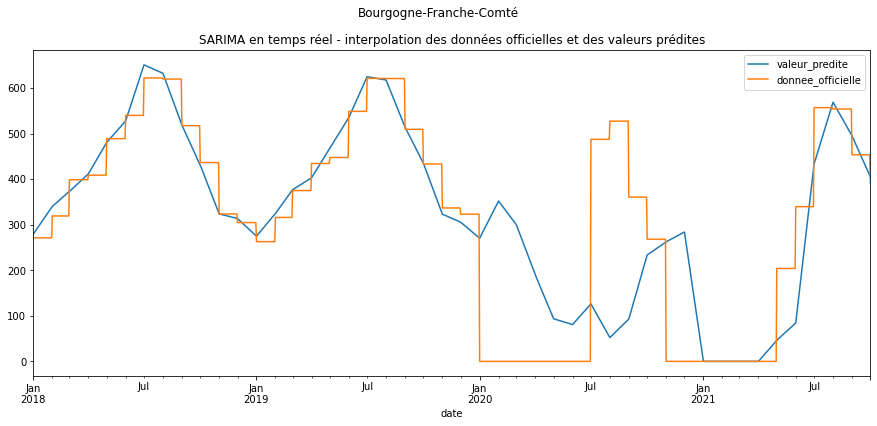

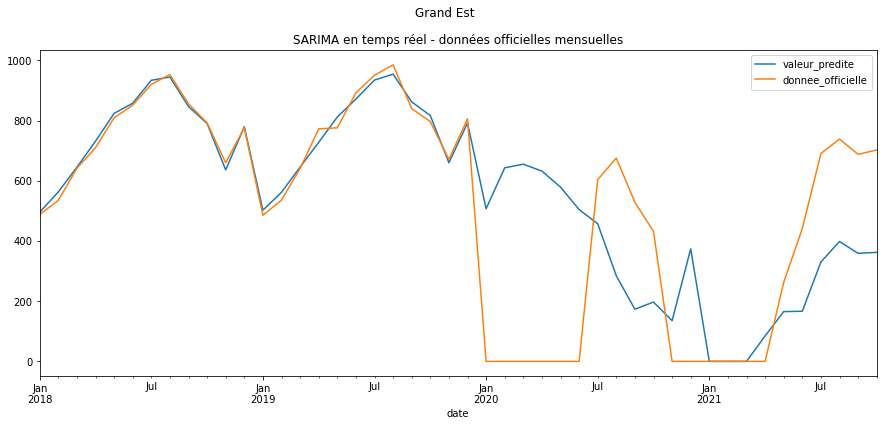

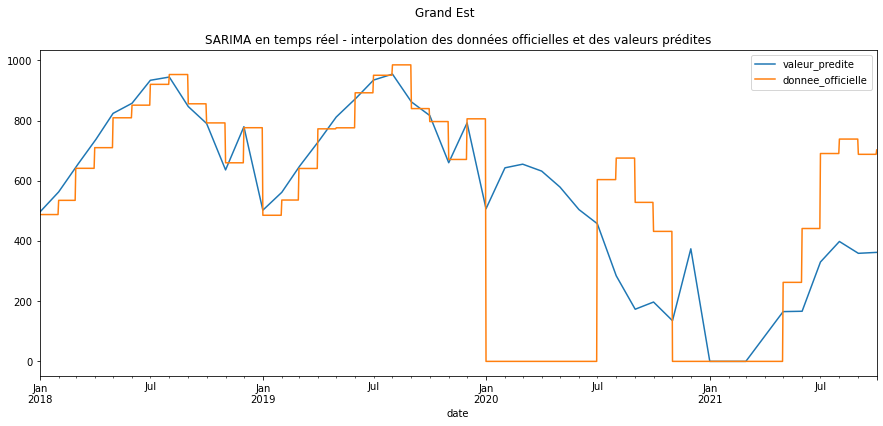

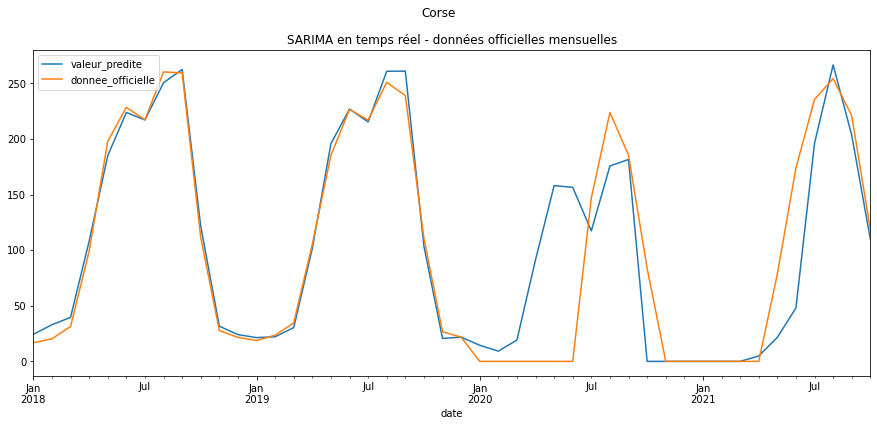

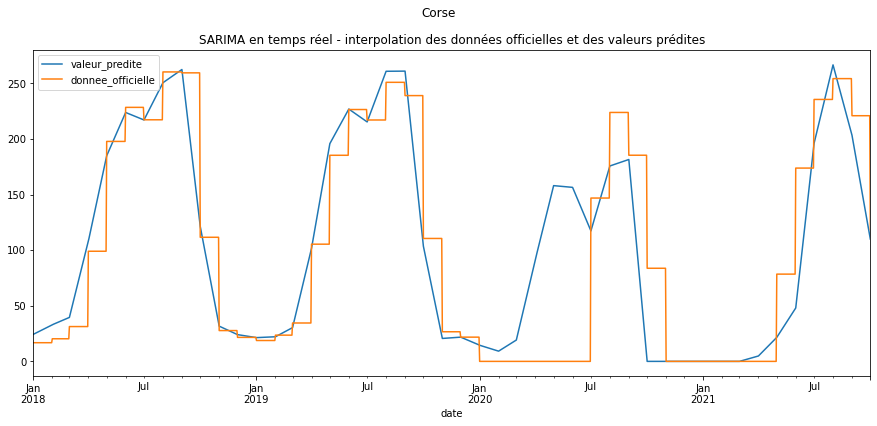

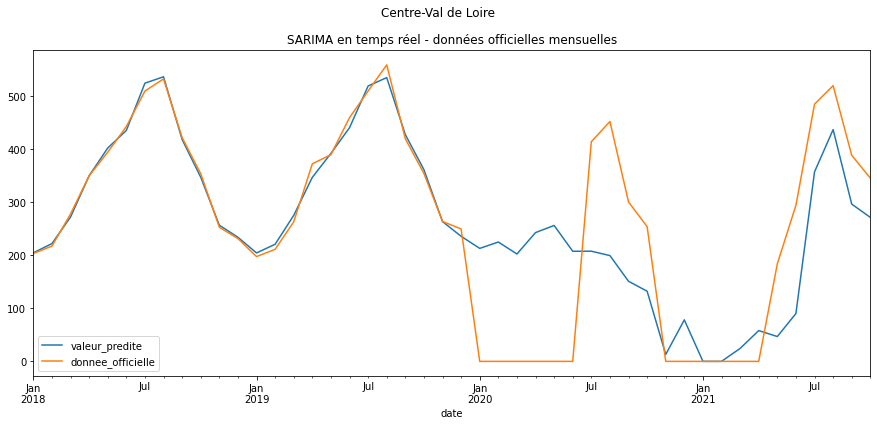

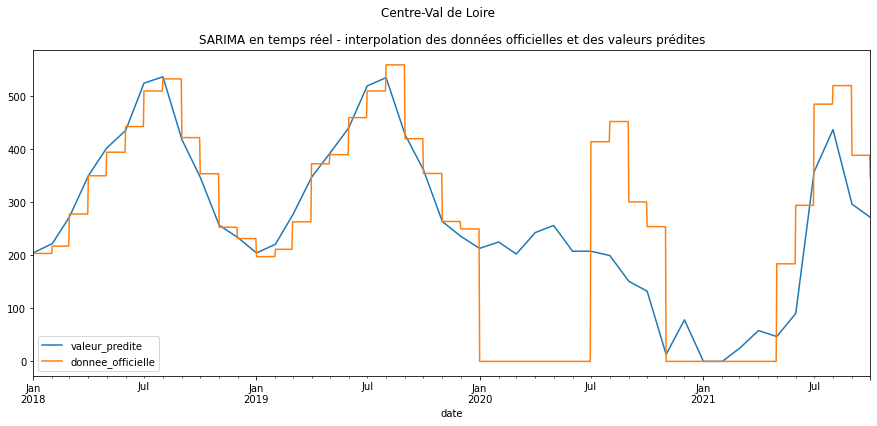

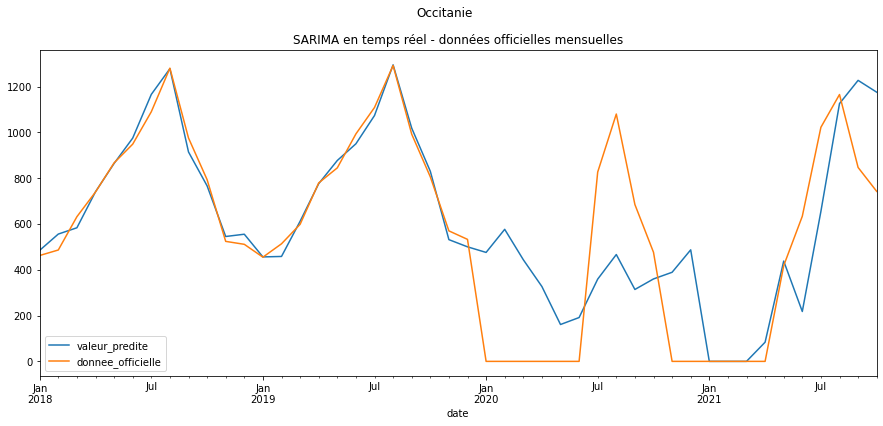

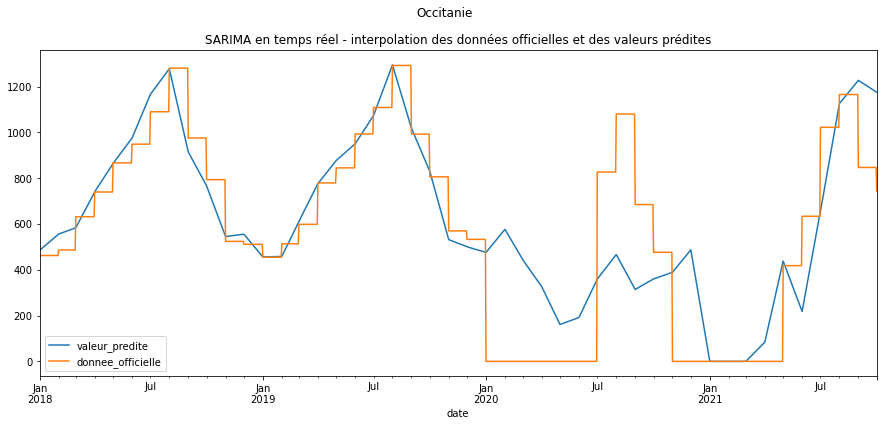

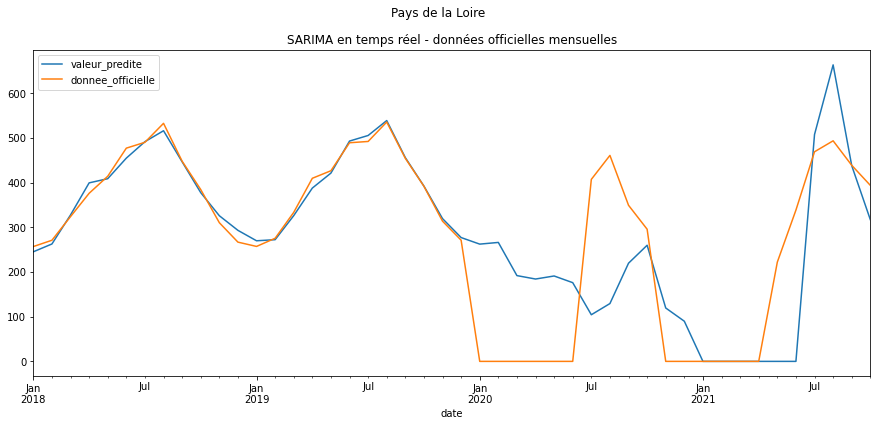

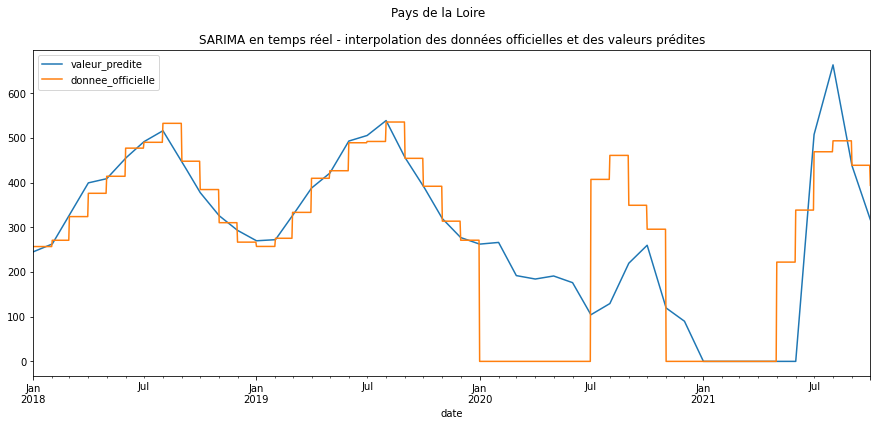

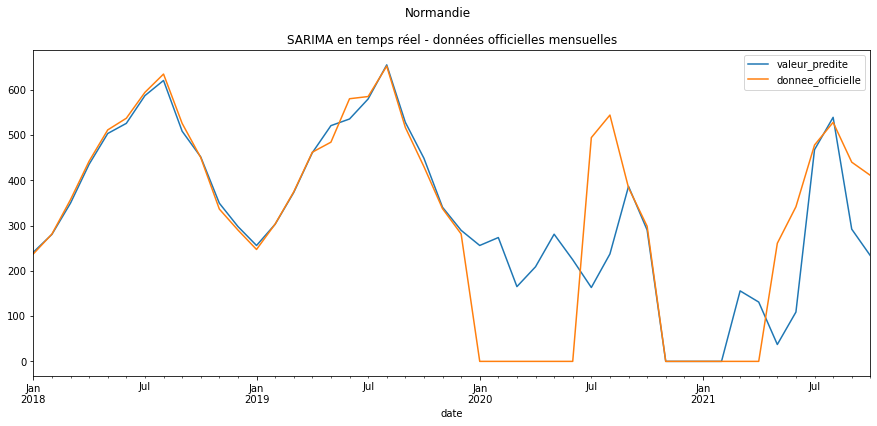

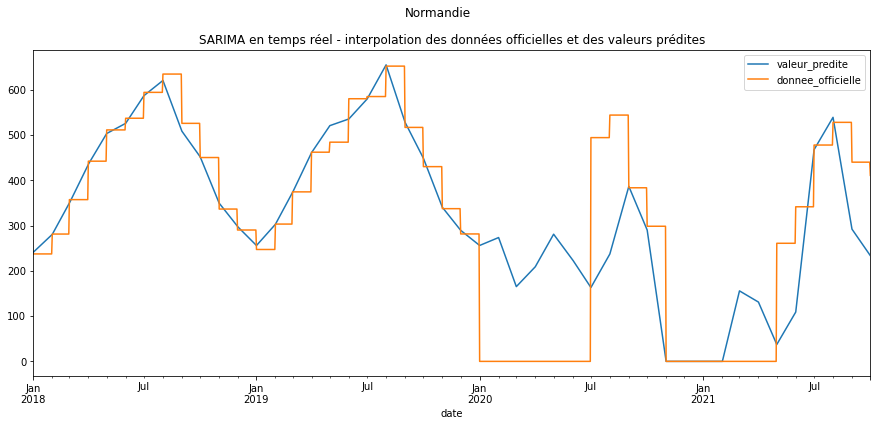

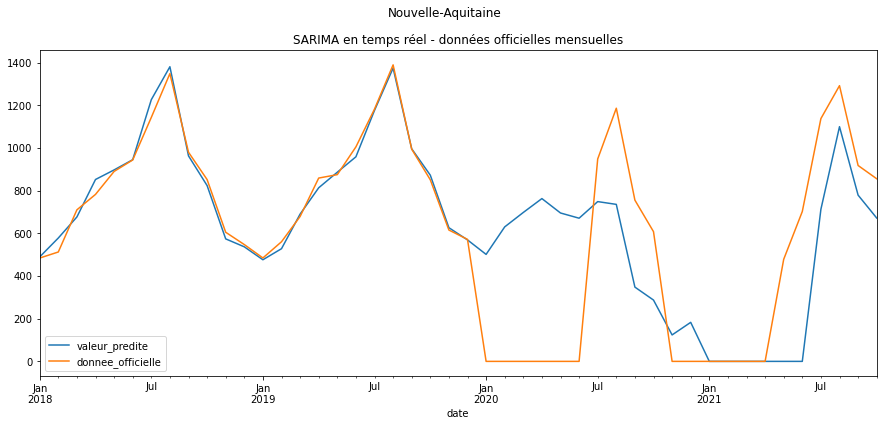

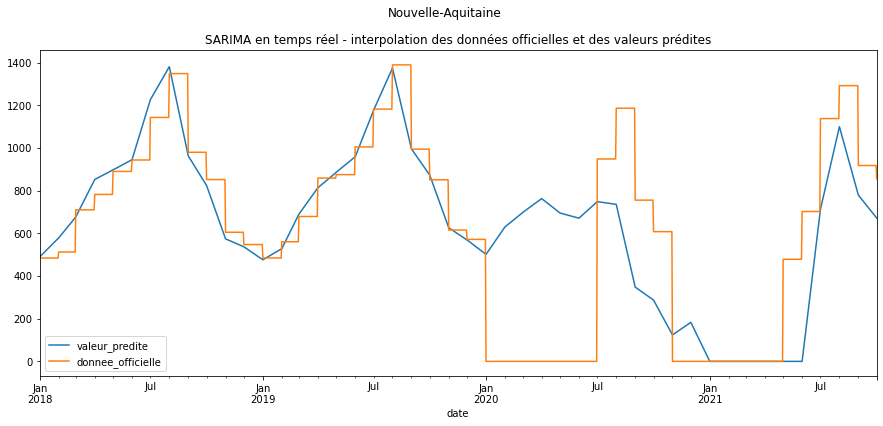

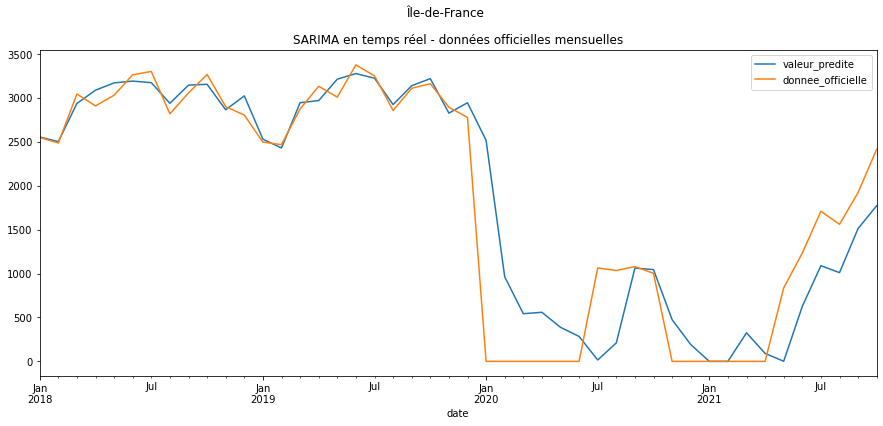

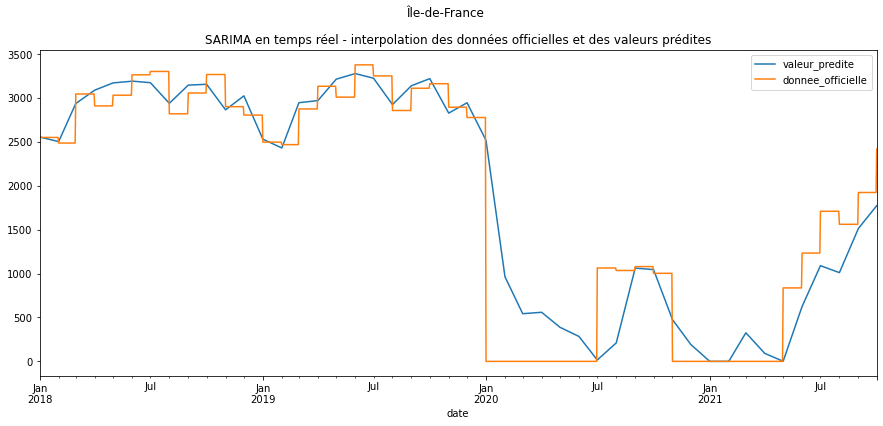

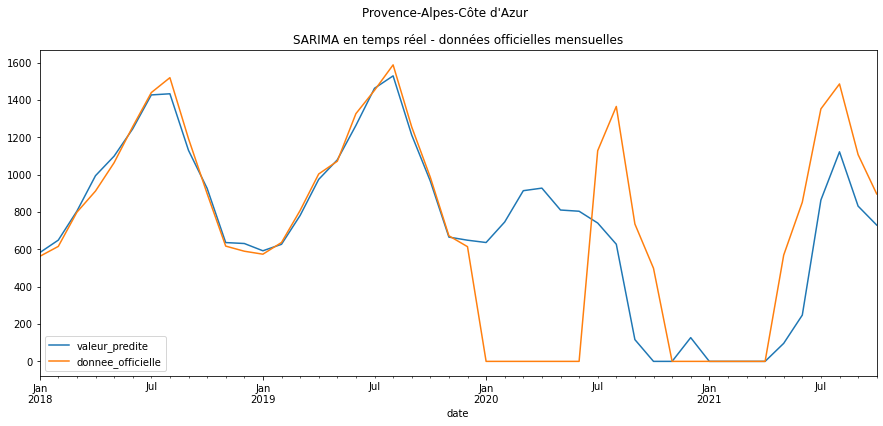

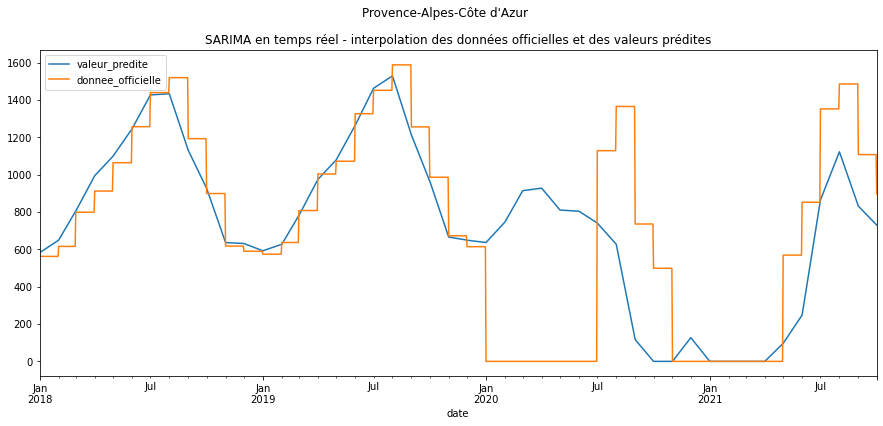

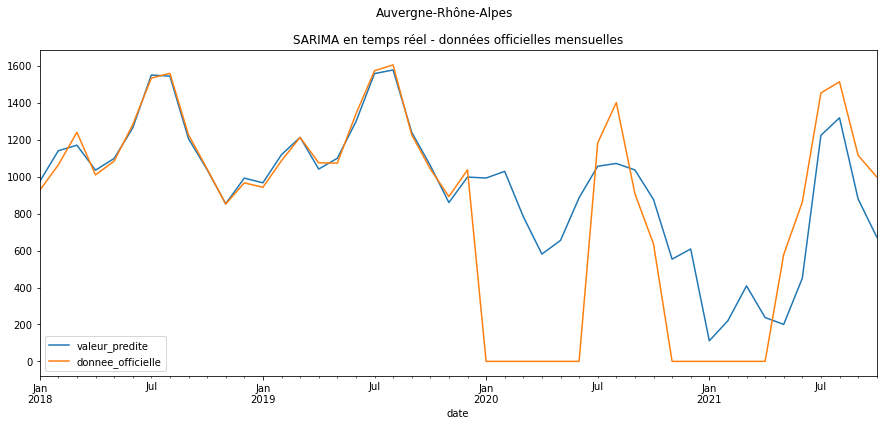

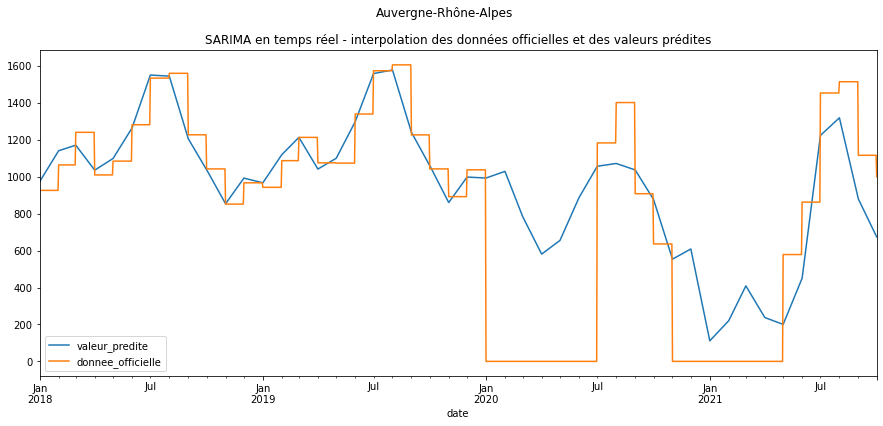

In [19]:
liste_regions = ['Bretagne', 'Hauts-de-France', 'Bourgogne-Franche-Comté', 'Grand Est', 'Corse', 'Centre-Val de Loire', 'Occitanie',
                 'Pays de la Loire', 'Normandie', 'Nouvelle-Aquitaine', 'Île-de-France', "Provence-Alpes-Côte d'Azur", "Auvergne-Rhône-Alpes"]

nb_touristes_sarima = pd.DataFrame()

df_bretagne = modele_donnees_off_jour_interpole('Bretagne', 6, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Bretagne"}).reset_index()
nb_touristes_sarima = df_bretagne

df_hauts_france = modele_donnees_off_jour_interpole('Hauts-de-France', 5, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Hauts-de-France"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_hauts_france, on="date")

df_bourgogne = modele_donnees_off_jour_interpole('Bourgogne-Franche-Comté', 5, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Bourgogne-Franche-Comté"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_bourgogne, on="date")

df_grand_est = modele_donnees_off_jour_interpole('Grand Est', 4, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Grand Est"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_grand_est, on="date")

df_corse = modele_donnees_off_jour_interpole('Corse', 6, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Corse"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_corse, on="date")

df_centre = modele_donnees_off_jour_interpole('Centre-Val de Loire', 6, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Centre-Val de Loire"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_centre, on="date")

df_occitanie = modele_donnees_off_jour_interpole('Occitanie', 5, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Occitanie"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_occitanie, on="date")

df_pays_loire = modele_donnees_off_jour_interpole('Pays de la Loire', 6, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Pays de la Loire"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_pays_loire, on="date")

df_normandie = modele_donnees_off_jour_interpole('Normandie', 6, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Normandie"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_normandie, on="date")

df_nouvelle_aquitaine = modele_donnees_off_jour_interpole('Nouvelle-Aquitaine', 3, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Nouvelle-Aquitaine"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_nouvelle_aquitaine, on="date")

df_ile_france = modele_donnees_off_jour_interpole('Île-de-France', 6, 2, 5).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Île-de-France"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_ile_france, on="date")

df_paca = modele_donnees_off_jour_interpole("Provence-Alpes-Côte d'Azur", 6, 1, 3).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Provence-Alpes-Côte d'Azur"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_paca, on="date")

df_auvergne_rhone_alpes = modele_donnees_off_jour_interpole("Auvergne-Rhône-Alpes", 5, 1, 4).drop("donnee_officielle", axis=1).rename(columns={"valeur_predite":"Auvergne-Rhône-Alpes"}).reset_index()
nb_touristes_sarima = nb_touristes_sarima.merge(df_auvergne_rhone_alpes, on="date")

nb_touristes_sarima

In [20]:
nb_touristes_sarima2 = nb_touristes_sarima.set_index("date")
somme_touristes = nb_touristes_sarima2.sum(axis=1)
nb_touristes_sarima2.insert(0, "France métropolitaine", somme_touristes)
nb_touristes_sarima3 = nb_touristes_sarima2.reset_index()
nb_touristes_sarima3

,date,France métropolitaine,Bretagne,Hauts-de-France,Bourgogne-Franche-Comté,Grand Est,Corse,Centre-Val de Loire,Occitanie,Pays de la Loire,Normandie,Nouvelle-Aquitaine,Île-de-France,Provence-Alpes-Côte d'Azur,Auvergne-Rhône-Alpes
0,2018-01-01,7167.409847,240.366053,348.504215,279.334014,495.596662,24.318664,204.755434,485.161548,245.299882,241.147464,489.795921,2556.671409,582.425875,974.032705
1,2018-01-02,7187.233205,241.434996,349.446339,281.289591,497.774001,24.596712,205.316895,487.449736,245.863217,242.418729,492.652638,2554.972344,584.592912,979.425094
2,2018-01-03,7207.056563,242.503939,350.388463,283.245167,499.951339,24.874760,205.878357,489.737924,246.426552,243.689995,495.509355,2553.273280,586.759950,984.817483
3,2018-01-04,7226.879920,243.572882,351.330587,285.200744,502.128677,25.152807,206.439818,492.026113,246.989887,244.961260,498.366072,2551.574215,588.926987,990.209871
4,2018-01-05,7246.703278,244.641826,352.272710,287.156321,504.306016,25.430855,207.001279,494.314301,247.553222,246.232526,501.222788,2549.875150,591.094025,995.602260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2021-09-27,7358.177375,311.769260,241.560235,417.163794,361.815087,122.396430,274.950195,1182.666867,333.351851,241.403661,686.428402,1739.329462,743.770997,701.571135
1366,2021-09-28,7334.657384,308.402874,241.087002,414.165170,361.920596,119.285460,274.115629,1180.945597,329.321902,239.452977,682.850979,1748.011122,740.384531,694.713546
1367,2021-09-29,7311.137393,305.036488,240.613770,411.166546,362.026105,116.174489,273.281062,1179.224327,325.291953,237.502292,679.273557,1756.692783,736.998064,687.855957
1368,2021-09-30,7287.617401,301.670102,240.140538,408.167921,362.131614,113.063518,272.446496,1177.503058,321.262004,235.551607,675.696135,1765.374444,733.611597,680.998368


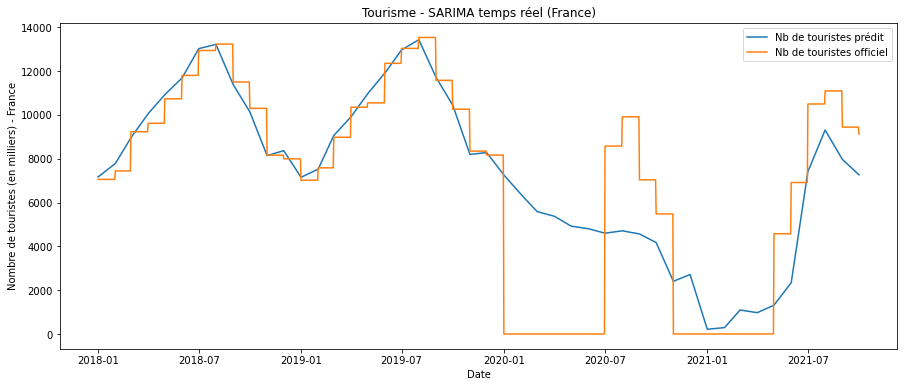

In [21]:
x = nb_touristes_sarima3["date"]

y1 = nb_touristes_sarima3["France métropolitaine"]

nb_touristes_off = df_France_Official_Data2.groupby('date').sum().reset_index()
df_days = pd.DataFrame(pd.date_range("2018-01-01", "2021-10-01")).rename(columns={0:"date"})
nb_touristes_off_jour = df_days.merge(nb_touristes_off, how="left").set_index('date')
nb_touristes_off_jour['value_in_thousands'] = nb_touristes_off_jour['value_in_thousands'].ffill()
y2 = nb_touristes_off_jour['value_in_thousands']

plt.figure(1, figsize=(15, 6))
plt.plot(x, y1, label="Nb de touristes prédit")
plt.plot(x, y2, label="Nb de touristes officiel")
plt.title('Tourisme - SARIMA temps réel (France)')
plt.xlabel('Date')
plt.ylabel("Nombre de touristes (en milliers) - France")
plt.legend()

In [22]:
#enregistre la base
nb_touristes_sarima3.to_csv("nb_touristes_sarima.csv")